# Laboratorio 5

Daniel Alfredo Rayo Roldán

Gerardo Gabriel Pineda Riveiro

Github: https://github.com/DanielRasho/DS-Lab4

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo
import re
from pathlib import Path
import pandas as pd
from prophet import Prophet

/home/smaug/Documents/DataScience/lab5/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Cargado de Datos

In [2]:
def cyanobacteria_index(path, show_rgb=False):
    with rasterio.open(path) as ds:
        arr = ds.read().astype(np.float32)  # shape: (bands, height, width)

    # Sentinel-2 band order assumption:
    # arr[0] = B01, arr[1] = B02, ..., arr[11] = B12
    # The script uses: B02, B03, B04, B05, B07, B08, B8A, B11, B12
    B02 = arr[1]
    B03 = arr[2]
    B04 = arr[3]
    B05 = arr[4]
    B07 = arr[6]
    B08 = arr[7]
    B8A = arr[8]
    B11 = arr[10]
    B12 = arr[11]

    MNDWI_threshold = 0.42
    NDWI_threshold = 0.4
    filter_UABS = True

    def wbi(r, g, b, nir, swir1, swir2):
        ndvi = (nir - r) / (nir + r)
        mndwi = (g - swir1) / (g + swir1)
        ndwi = (g - nir) / (g + nir)
        ndwi_leaves = (nir - swir1) / (nir + swir1)
        aweish = b + 2.5 * g - 1.5 * (nir + swir1) - 0.25 * swir2
        aweinsh = 4 * (g - swir1) - (0.25 * nir + 2.75 * swir1)
        dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
        # wii, wri, puwi, uwi, usi are not used in filtering
        ws = (
            (mndwi > MNDWI_threshold)
            | (ndwi > NDWI_threshold)
            | (aweinsh > 0.1879)
            | (aweish > 0.1112)
            | (ndvi < -0.2)
            | (ndwi_leaves > 1)
        )
        if filter_UABS:
            ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))
        return ws.astype(np.uint8)

    water = wbi(B04, B03, B02, B08, B11, B12)

    # Floating vegetation index
    def FAI(a, b, c):
        return b - a - (c - a) * (783 - 665) / (865 - 665)

    FAIv = FAI(B04, B07, B8A)

    # NDCI and chlorophyll
    def NDCI(a, b):
        return (b - a) / (b + a)

    NDCIv = NDCI(B04, B05)
    

    chl = 826.57 * NDCIv**3 - 176.43 * NDCIv**2 + 19 * NDCIv + 4.071
    
    if show_rgb:
        # Output RGB image
        rgb = np.zeros((3, arr.shape[1], arr.shape[2]), dtype=np.float32)

        # True color (non-water)
        true_color = np.stack((3 * B04, 3 * B03, 3 * B02))
        mask_nonwater = water == 0
        rgb[:, mask_nonwater] = true_color[:, mask_nonwater]

        # Floating vegetation
        mask_fai = (water == 1) & (FAIv > 0.08)
        rgb[:, mask_fai] = np.array([233/255, 72/255, 21/255])[:, None]

        # Chlorophyll ranges
        chl_ranges = [
            (0.5, [0, 0, 1.0]),
            (1,   [0, 0, 1.0]),
            (2.5, [0, 59/255, 1]),
            (3.5, [0, 98/255, 1]),
            (5,   [15/255, 113/255, 141/255]),
            (7,   [14/255, 141/255, 120/255]),
            (8,   [13/255, 141/255, 103/255]),
            (10,  [30/255, 226/255, 28/255]),
            (14,  [42/255, 226/255, 28/255]),
            (18,  [68/255, 226/255, 28/255]),
            (20,  [68/255, 226/255, 28/255]),
            (24,  [134/255, 247/255, 0]),
            (28,  [140/255, 247/255, 0]),
            (30,  [205/255, 237/255, 0]),
            (38,  [208/255, 240/255, 0]),
            (45,  [208/255, 240/255, 0]),
            (50,  [251/255, 210/255, 3/255]),
            (75,  [248/255, 207/255, 2/255]),
            (90,  [134/255, 247/255, 0]),
            (100, [245/255, 164/255, 9/255]),
            (150, [240/255, 159/255, 8/255]),
            (250, [237/255, 157/255, 7/255]),
            (300, [239/255, 118/255, 15/255]),
            (350, [239/255, 101/255, 15/255]),
            (450, [239/255, 100/255, 14/255]),
            (500, [233/255, 72/255, 21/255]),
        ]

        mask_remaining = (water == 1) & ~(FAIv > 0.08)
        for limit, color in chl_ranges:
            mask = mask_remaining & (chl < limit)
            rgb[:, mask] = np.array(color)[:, None]
            mask_remaining &= ~(chl < limit)

        # Above max threshold
        rgb[:, mask_remaining] = np.array([233/255, 72/255, 21/255])[:, None]

        return rgb
    else:
        # Create output array with NaNs for non-water or floating vegetation
        output = np.full_like(chl, np.nan, dtype=np.float32)

        mask_water = water
        mask_floating_veg = mask_water & (FAIv > 0.08)
        mask_chl = mask_water & ~mask_floating_veg

        # Assign chlorophyll values only where valid
        output[mask_chl] = chl[mask_chl]

        return output

In [3]:
amatitlan_images = {
    '2025-01-13': 'cianobacteria_amatitlan-2025-01-13.tif',    
    '2025-01-18': 'cianobacteria_amatitlan-2025-01-18.tif',    
    '2025-02-07': 'cianobacteria_amatitlan-2025-02-07.tif',    
    '2025-03-04': 'cianobacteria_amatitlan-2025-03-04.tif',    
    '2025-03-19': 'cianobacteria_amatitlan-2025-03-19.tif',    
}

atitlan_images = {

}

In [11]:
dates = []
index_value = []

def getIndexPerDate(basepath, selected_images):
    results = {}
    for date, fname in selected_images.items():
        tif_path = basepath / fname
        with rasterio.open(tif_path) as ds:
            chl_map = cyanobacteria_index(tif_path)
            mean_chl = np.nanmean(chl_map)
            index_value.append(mean_chl)
            dates.append(date)

getIndexPerDate(Path("./data"), amatitlan_images)
df = pd.DataFrame.from_dict({'Fecha': dates, 'Indice': index_value})
df

/tmp/ipykernel_3151/632298091.py:23: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir - r) / (nir + r)
/tmp/ipykernel_3151/632298091.py:25: RuntimeWarning: divide by zero encountered in divide
  ndwi = (g - nir) / (g + nir)
/tmp/ipykernel_3151/632298091.py:26: RuntimeWarning: divide by zero encountered in divide
  ndwi_leaves = (nir - swir1) / (nir + swir1)


,Fecha,Indice
0,2025-01-13,29.906590
1,2025-01-18,26.389694
2,2025-02-07,24.313160
3,2025-03-04,14.337477
4,2025-03-19,10.794349


# Modelos Temporales

17:05:46 - cmdstanpy - INFO - Chain [1] start processing
17:05:46 - cmdstanpy - INFO - Chain [1] done processing


           ds        yhat  yhat_lower  yhat_upper
0  2025-01-13   29.906526   29.906526   29.906526
1  2025-01-18   26.389625   26.389625   26.389625
2  2025-02-07   24.313322   24.313322   24.313322
3  2025-03-04   14.337324   14.337324   14.337324
4  2025-03-19   10.794414   10.794414   10.794414
5  2025-03-20 -451.493308 -451.493308 -451.493308
6  2025-03-21  -30.272682  -30.272682  -30.272682
7  2025-03-22  -55.489381  -55.489381  -55.489381
8  2025-03-23 -181.797533 -181.797533 -181.797533
9  2025-03-24  -61.070147  -61.070147  -61.070147
10 2025-03-25  -12.955678  -12.955678  -12.955678
11 2025-03-26    1.696747    1.696747    1.696747
12 2025-03-27 -460.590975 -460.590976 -460.590975
13 2025-03-28  -39.370349  -39.370349  -39.370349
14 2025-03-29  -64.587048  -64.587048  -64.587048
15 2025-03-30 -190.895200 -190.895200 -190.895200
16 2025-03-31  -70.167815  -70.167815  -70.167815
17 2025-04-01  -22.053346  -22.053346  -22.053346
18 2025-04-02   -7.400920   -7.400920   -7.400920


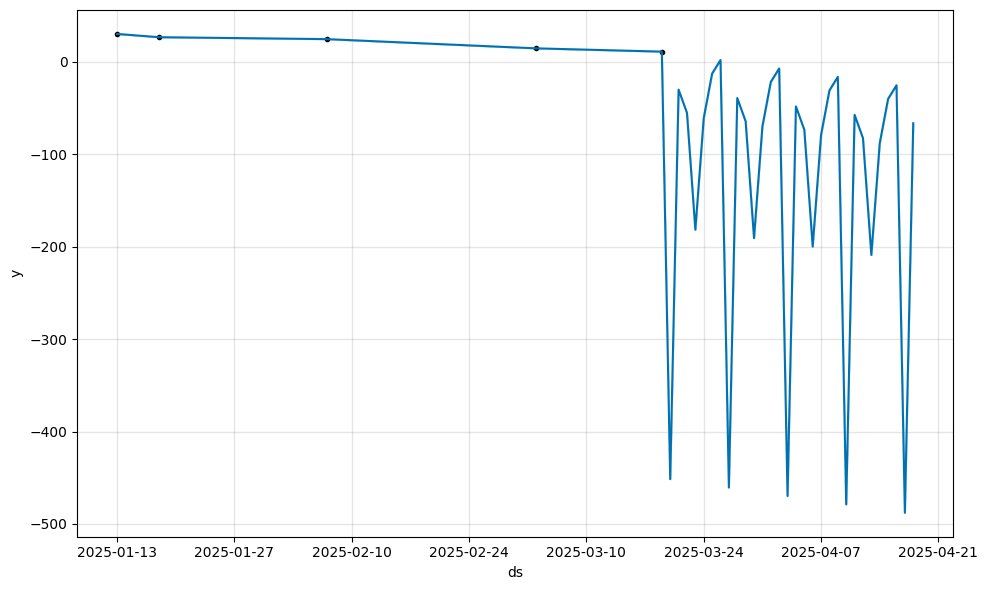

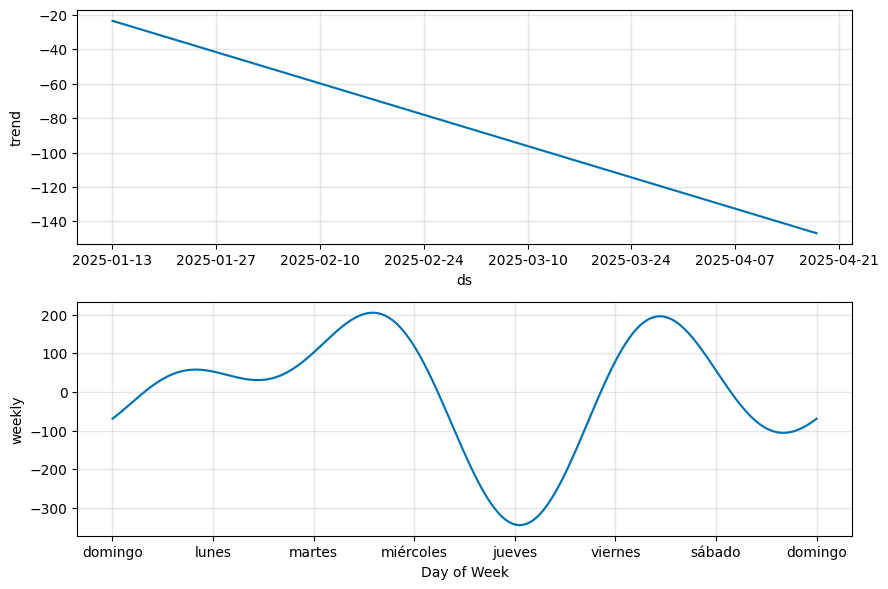

In [13]:
# Ensure date is datetime
df["Fecha"] = pd.to_datetime(df["Fecha"])

# Rename columns for Prophet
df_prophet = df.rename(columns={"Fecha": "ds", "Indice": "y"})

# Create and fit the model
model = Prophet()
model.fit(df_prophet)

# Create a future dataframe (e.g., forecast for next 30 days)
future = model.make_future_dataframe(periods=30)  # daily frequency by default
forecast = model.predict(future)

# See the forecast
print(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]])

# Plot the forecast
model.plot(forecast)
model.plot_components(forecast);